In [46]:
import os 
from dotenv import load_dotenv
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage

load_dotenv()

True

In [47]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

In [48]:
class CityDetails(BaseModel):
    state_name: str = Field("State name of the city")
    state_capital: str = Field("State capital of the city")
    country_name: str = Field("Country name of the city")
    country_capital: str = Field("Country capital of the city")

In [49]:
tool = TavilySearchResults()

tools = [tool]

In [50]:
llm_with_tool = llm.bind_tools(tools)

In [51]:
llm_with_structure_outout = llm.with_structured_output(CityDetails)

In [52]:
class AgentState(MessagesState):
    final_response: CityDetails

In [53]:
def call_model(state: AgentState):
    print(" -- call model --")
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [54]:
def should_continue(state: AgentState):
    print(" -- should continue --")
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "respond"
    else:
        return "continue"

In [55]:
def respond(state: AgentState):
    print("-- respond --")
    messages = state['messages']
    last_messages = messages[-1]
    response = llm_with_structure_outout.invoke(last_messages.content)
    # response = llm_with_structure_outout.invoke([HumanMessage(content=state['messages'][-1].content)])
    return {"final_response": response}

In [56]:
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

workflow.add_edge(START, "llm")
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond"
    }
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)

app = workflow.compile()

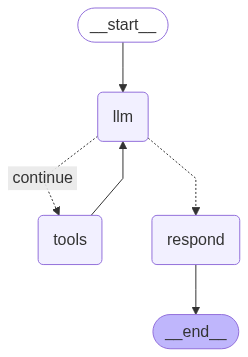

In [57]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [58]:
answer = app.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']

 -- call model --
 -- should continue --
 -- call model --
 -- should continue --
-- respond --


In [59]:
answer

CityDetails(state_name='Madhya Pradesh', state_capital='No', country_name='India', country_capital='No')

In [63]:
answer = app.stream(input={"messages": [("human", "Tell me about the city details for gwalior?")]}, stream_mode="values")

In [64]:
for event in answer:
    if event.get('final_response'):
        print(event['final_response'])

 -- call model --
 -- should continue --
 -- call model --
 -- should continue --
-- respond --
state_name='Madhya Pradesh' state_capital='Bhopal' country_name='India' country_capital='New Delhi'


In [61]:
for event in answer:
    if event.get('final_response'):
        final_output = event['final_response']
        
if final_output:
    print(final_output)

 -- call model --
 -- should continue --
 -- call model --
 -- should continue --
-- respond --
state_name='Madhya Pradesh' state_capital='Bhopal' country_name='India' country_capital='New Delhi'


In [65]:
for event in answer:
    for key, value in event.items():
        print(f"Node: {key}")
        print(value)
        print("===")
    